First cell is necessary for running this notebook with django env (as if it was executed from an API call).

In [1]:
import os, sys
DJANGO_ROOT = os.path.abspath(os.path.join(os.getcwd(),'../../'))
sys.path.insert(0,DJANGO_ROOT)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()

In [2]:
from app.models import Profile, Image, LikedImages
import pickle as pckl

# Like image

In [ ]:
data = {'like': False, 'id':1 }

In [ ]:
user = User.objects.all().first()

In [ ]:
profile = Profile.objects.all().first()

In [ ]:
# import numpy as np
# profile.pref_vec = pckl.dumps( np.zeros_like(pckl.loads(str(profile.pref_vec))))
# profile.img_count = 0
# profile.save()

In [ ]:
query_res = LikedImages.objects.filter(user= user.id, img=data['id'] )

if data['like']:
    # Add the image to list if it's not there yet
    if len(query_res) is 0:
        image = Image.objects.filter(id=data['id']).first()

        # update user preferences
        profile = Profile.objects.filter(user_id=user.id).first()
        profile_vec = pckl.loads(str(profile.pref_vec))
        img_vec     = pckl.loads(str(image.txt_vec))

        profile_vec = ((profile_vec * profile.img_count) + img_vec) / (profile.img_count + 1 )
        profile.img_count += 1
        profile.pref_vec = pckl.dumps(profile_vec)
        profile.save()

        # save like
        li = LikedImages(user=user, img=image)
        li.save()
else:
    if len(query_res) is 1:
        result = query_res.first()
        
        # update user preferences
        profile = Profile.objects.filter(user_id=user.id).first()
        profile_vec = pckl.loads(str(profile.pref_vec))
        img_vec     = pckl.loads(str(result.img.txt_vec))

        profile_vec = ((profile_vec * profile.img_count) - img_vec)
        profile_vec = profile_vec if profile.img_count == 1 else profile_vec / (profile.img_count - 1 )
        profile.img_count -= 1
        profile.pref_vec = pckl.dumps(profile_vec)
        profile.save()
        
        result.delete()

In [ ]:
len(LikedImages.objects.all())

Test for succ user update:

In [ ]:
user = Profile.objects.all().first()

In [ ]:
pckl.loads(str(user.pref_vec))

In [ ]:
Profile.objects.first().img_count

# Retrieve recommendations

In [ ]:
from django.contrib.auth.models import User

In [ ]:
images = Image.objects.all()

In [ ]:
user = User.objects.all().first()
profile = Profile.objects.filter(user_id = user.id).first()

In [ ]:
pref_vec = pckl.loads(str(profile.pref_vec))

In [ ]:
sim = []
for img in images:
    img_vec = pckl.loads(str(img.txt_vec)) 
    similarity = np.arccos(np.dot(img_vec,pref_vec) / (np.linalg.norm(img_vec) * np.linalg.norm(pref_vec))) 
    sim.append( (img.id,similarity))

In [ ]:
sim.sort(key=lambda tup: tup[1])

In [ ]:
top_k = 16
indices = map(lambda rec: rec[0], sim[:top_k])

In [ ]:
indices

In [ ]:
Image.objects.filter(id__in = indices)

# Retrieve recommendations (proper way)

In [13]:
from django.contrib.auth.models import User
from app.models import Image
from project.project_config import empty_embed_vec, obj2pickled , pickled2obj, GALLERY_IMG_NUM
from tqdm import tqdm
import numpy as np

In [14]:
images = Image.objects.all()

In [15]:
user = User.objects.all().first()
profile = Profile.objects.filter(user_id = user.id).first()

In [16]:
#user = self.request.user
images = Image.objects.all().exclude(id__in=LikedImages.objects.filter(user=user).values_list('img', flat=True))
liked_images = Image.objects.all().filter(id__in=LikedImages.objects.filter(user=user).values_list('img', flat=True))

In [17]:
total_liked_count = len(liked_images)

In [ ]:
# From liked images extract the number of classes and mean vec for each label
usr_class_emb = {}
for image in liked_images:
    if image.label not in usr_class_emb:
        class_emb = {'vec':empty_embed_vec(), 'count':0}
    else:
        class_emb = usr_class_emb[image.label]
    class_emb['vec'] += pickled2obj(image.txt_vec)
    class_emb['count'] +=1
    usr_class_emb[image.label] = class_emb
    
for _,val in usr_class_emb.items():
    val['vec'] /= val['count']

In [ ]:
def find_similar(pref_vec,images=None, k_similar=20):
    if images is None:
        images = Image.objects.all().exclude(id__in=LikedImages.objects.filter(user=user).values_list('img', flat=True))
    sim = []
    for img in images:
        img_vec = pickled2obj(img.txt_vec)
        similarity = np.arccos(np.dot(img_vec, pref_vec) / (np.linalg.norm(img_vec) * np.linalg.norm(pref_vec)))
        sim.append((img.id, similarity))

    sim.sort(key=lambda tup: tup[1])
    indices = map(lambda rec: rec[0], sim[:k_similar])
    return indices

In [ ]:
# Fetch k similar for each class and then
output_images_indices = []
class_count = len(usr_class_emb)
for val in usr_class_emb.values():
    class_count -= 1
    pref_vec = val['vec']
    sim_img_count = round(val['count'] / total_liked_count * GALLERY_IMG_NUM) 
    if class_count is 0:
        sim_img_count = GALLERY_IMG_NUM - len(output_images)
    sim_image_indices = find_similar(pref_vec, images, sim_img_count)
    output_images_indices += sim_image_indices

In [ ]:
Image.objects.filter(id__in = output_images_indices)

# Insert default value to Image.objects instance

Search for `mock-django` to mock queryset with speific data.

In [14]:
from app.models import Image
from django.db.models.query import QuerySet
from project.project_config import empty_embed_vec

In [15]:
error_img = Image(-1, 'static/img/no_images.jpg',-1,empty_embed_vec())

In [18]:
qs = QuerySet(error_img)

In [ ]:
qs

# Data inspect

In [25]:
from app.models import Image, User
from imageio import imread
import matplotlib.pyplot as plt

In [61]:
bad_label = 861

In [62]:
img_bad = Image.objects.filter(id=bad_label).first()

In [63]:
def load_img(path):
    return imread(os.path.join( DJANGO_ROOT, path))

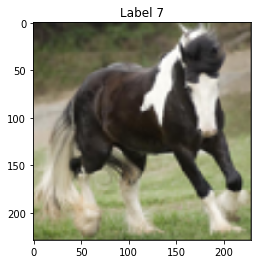

In [68]:
plt.imshow(load_img(img_bad.path))
plt.title('Label {}'.format(img_bad.label));

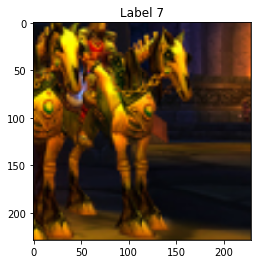

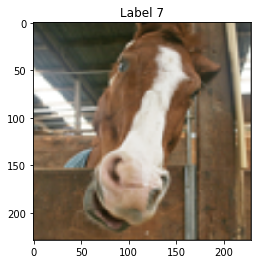

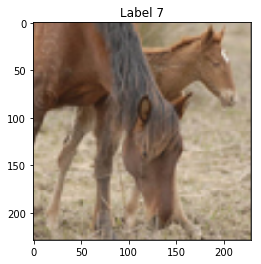

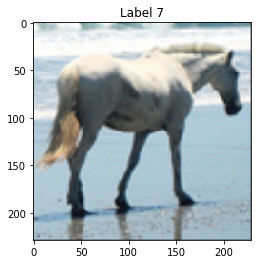

In [71]:
img_class_l = Image.objects.filter(label=img_bad.label)
for i, img_class in enumerate(img_class_l):
    plt.imshow(load_img(img_class.path))
    plt.title('Label {}'.format(img_class.label))
    plt.show()
    if i >= 3:
        break

In [35]:
user = User.objects.first()

**Add a random like:**

Text(0.5,1,'Label 6')

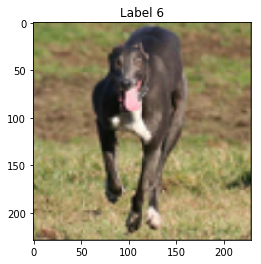

In [73]:
image = Image.objects.filter(id=2).first()
plt.imshow(load_img(image.path))
plt.title('Label {}'.format(image.label))

In [74]:
li = LikedImages(user=user, img=image)
li.save()

**Recommender procedure** :

In [113]:
# util
import pickle as pckl
import numpy as np
import codecs

DESCRIPTOR_VEC_SHAPE = [300,]
GALLERY_IMG_NUM = 20

def empty_embed_vec():
    return np.zeros(DESCRIPTOR_VEC_SHAPE)

def obj2pickled(obj):
    return codecs.encode(pckl.dumps(obj), "base64").decode()

def pickled2obj(pickled):
    return pckl.loads(codecs.decode(pickled.encode(), "base64"))

def find_similar(pref_vec,images, k_similar=20):
    sim = []
    for img in images:
        img_vec = pickled2obj(img.txt_vec)
        similarity = np.arccos(np.dot(img_vec, pref_vec) / (np.linalg.norm(img_vec) * np.linalg.norm(pref_vec)))
        sim.append((img.id, similarity))

    sim.sort(key=lambda tup: tup[1])
    indices = map(lambda rec: rec[0], sim[:k_similar])
    return indices

In [128]:
res = []

In [129]:
images = Image.objects.all().exclude(id__in=LikedImages.objects.filter(user=user).values_list('img', flat=True))
liked_images = Image.objects.all().filter(id__in=LikedImages.objects.filter(user=user).values_list('img', flat=True))

In [130]:
if len(liked_images) is 0:
    res = Image.objects.none() # Here return an image object in list
    raise Exception('Stop')

In [131]:
total_liked_count = len(liked_images)
# From liked images extract the number of classes and mean vec for each label
usr_class_emb = {}
for image in liked_images:
    if image.label not in usr_class_emb:
        class_emb = {'vec': empty_embed_vec(), 'count': 0}
    else:
        class_emb = usr_class_emb[image.label]
    class_emb['vec'] += pickled2obj(image.txt_vec)
    class_emb['count'] += 1
    usr_class_emb[image.label] = class_emb

In [132]:
usr_class_emb_ = usr_class_emb

In [133]:
for val in usr_class_emb.values():
    val['vec'] /= val['count']

In [137]:
usr_class_emb[6]['vec'] - usr_class_emb_[6]['vec']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [119]:
# Fetch k similar for each class and then
output_images_indices = []
class_count = len(usr_class_emb)

In [123]:
for label, record in usr_class_emb.items():
    class_count -= 1
    pref_vec = record['vec']
    sim_img_count = round(record['count'] / total_liked_count * GALLERY_IMG_NUM)
    if class_count is 0:
        sim_img_count = GALLERY_IMG_NUM - len(output_images_indices )
    sim_image_indices = find_similar(pref_vec, images.filter(label=label), sim_img_count)
    output_images_indices += sim_image_indices

In [124]:
if len(output_images_indices) is 0:
    res =  Image.objects.none()
    raise Exception('Stop')

In [125]:
res = Image.objects.filter(id__in = output_images_indices)

---

In [127]:
res

<QuerySet [<Image: path: static/img/recdemo/id@72.png | label: 6 | txt_vec: gANjbnVtcHkuY29yZS5tdWx0aWFycmF5Cl9yZWNvbnN0cnVjdApxAGNudW1weQpuZGFycmF5CnEB
SwCFcQJDAWJxA4dxBFJxBShLAU0sAYVxBmNudW1weQpkdHlwZQpxB1gCAAAAZjhxCEsASwGHcQlS
cQooSwNYAQAAADxxC05OTkr/////Sv////9LAHRxDGKJQmAJAAD8INUXoVwvwMRkb6laQTXAkzjb
XOpGNEBwVDST24E6wO1PpcpsXRLABl7z5D1/KsC9/9T5bXEtwE6vwazAEQFAQWOdRmhWBcB7y5wi
yp4VwHnmbOa9Hi/AoCkJfwfegz8xREk6YCH2vyEWDiKEIzXAiLKz0rZ/8T9UU3RM7tEfQA1hArYY
kxNAI4tuv5lOHUDHfWmA0CURwNf5hRAOcTNAd0fmFWTt6b8kZes984IawNRbMArucSdAWP8nSKN9
B8DOGjgGp84hwPfOS8LG4AvAAIi2dHgbfD9M+NhFpzsfQHP4C9OKvSHARgmRz9T5JcAs8JsXhN8D
QDAu5kLJRCJAcG8+Gk5xJ8CSw7j3HnIjwPU28VycYhNAAMcpf9qyIkBI0J5nsCIXwDRJKknwYBrA
wJq7zEKhHED83zy3i5QCQOIhfQ/M5RZAwzQSlSoyHkDG5WOkyQIjQBX2Yu+QCCPAYIUtX8tSA8Cc
4/UUaeXyvzR6Pk1CuCBAM0QQPx4nE8BhGMhjik4VwFDARt7qGiZALKyipkwPHMCXtnIQpK7yP0lA
7pw1GRFAJlN5XcoJFMARqtHkenkAwAV7ZnRnZtc/qXRhtOPbAsB/xyMNU43Zv/Yah4l0dQVAxquR
i0LW878E/jXJlFMOQBF7zyHXCxTARMwT9fh0A8DsYY9gl9AhQIX7P2ShDB3A8vjxWpNEDEDWFoI4
